In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [3]:
df = pd.read_csv('supply_chain_data.csv')

In [4]:
df.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [5]:
df.shape

(100, 24)

In [6]:
df.describe()
#Descriptive Values from different columns of the dataset

,Price,Availability,Number of products sold,Revenue generated,Stock levels,Lead times,Order quantities,Shipping times,Shipping costs,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Defect rates,Costs
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,49.462461,48.400000,460.990000,5776.048187,47.770000,15.960000,49.220000,5.750000,5.548149,17.080000,567.840000,14.77000,47.266693,2.277158,529.245782
std,31.168193,30.743317,303.780074,2732.841744,31.369372,8.785801,26.784429,2.724283,2.651376,8.846251,263.046861,8.91243,28.982841,1.461366,258.301696
min,1.699976,1.000000,8.000000,1061.618523,0.000000,1.000000,1.000000,1.000000,1.013487,1.000000,104.000000,1.00000,1.085069,0.018608,103.916248
25%,19.597823,22.750000,184.250000,2812.847151,16.750000,8.000000,26.000000,3.750000,3.540248,10.000000,352.000000,7.00000,22.983299,1.009650,318.778455
50%,51.239831,43.500000,392.500000,6006.352023,47.500000,17.000000,52.000000,6.000000,5.320534,18.000000,568.500000,14.00000,45.905622,2.141863,520.430444
75%,77.198228,75.000000,704.250000,8253.976921,73.000000,24.000000,71.250000,8.000000,7.601695,25.000000,797.000000,23.00000,68.621026,3.563995,763.078231
max,99.171329,100.000000,996.000000,9866.465458,100.000000,30.000000,96.000000,10.000000,9.929816,30.000000,985.000000,30.00000,99.466109,4.939255,997.413450


In [5]:
df.isnull().sum()
#There are no missing values in the dataset

Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score


# ---------- REORDER-POINT & SAFETY-STOCK ----------
def reorder_point_safety_stock(data, service_level_z=1.65):
    """
    Calculates single-echelon reorder point (ROP) and safety stock (SS)
    based on daily demand volatility.

    Parameters
    ----------
    data : DataFrame – must contain 'Number of products sold' and 'Lead times'
    service_level_z : float – Z-score for desired cycle-service level
                       (1.65 ≈ 95%)

    Returns
    -------
    tuple : (reorder_point, safety_stock)
    """
    data = data.copy()
    # daily demand per SKU
    data["daily_demand"] = data["Number of products sold"] / data["Lead times"]

    mean_demand = data["daily_demand"].mean()
    std_demand  = data["daily_demand"].std()
    avg_lead    = data["Lead times"].mean()

    # print("Mean daily demand :", data['daily_demand'].mean())
    # print("Std daily demand  :", data['daily_demand'].std())
    # print("Avg lead-time (d) :", data['Lead times'].mean())

    safety_stock  = service_level_z * std_demand * np.sqrt(avg_lead)
    reorder_point = mean_demand * avg_lead + safety_stock
    return reorder_point, safety_stock

rop, ss = reorder_point_safety_stock(df)
print(f"Reorder point ≈ {rop:,.0f} units")
print(f"Safety stock  ≈ {ss:,.0f} units")


Reorder point ≈ 2,208 units
Safety stock  ≈ 1,021 units


In [7]:
categorical_columns = ['Product type','Customer demographics', 'Shipping carriers', 'Supplier name', 'Location','Location','Inspection results','Transportation modes','Routes']
df2 = pd.get_dummies(df, columns=categorical_columns)
df2.head()
#Converted categorical variables using one hot encoding for analysis


,SKU,Price,Availability,Number of products sold,Revenue generated,Stock levels,Lead times,Order quantities,Shipping times,Shipping costs,...,Inspection results_Fail,Inspection results_Pass,Inspection results_Pending,Transportation modes_Air,Transportation modes_Rail,Transportation modes_Road,Transportation modes_Sea,Routes_Route A,Routes_Route B,Routes_Route C
0,SKU0,69.808006,55,802,8661.996792,58,7,96,4,2.956572,...,False,False,True,False,False,True,False,False,True,False
1,SKU1,14.843523,95,736,7460.900065,53,30,37,2,9.716575,...,False,False,True,False,False,True,False,False,True,False
2,SKU2,11.319683,34,8,9577.749626,1,10,88,2,8.054479,...,False,False,True,True,False,False,False,False,False,True
3,SKU3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,...,True,False,False,False,True,False,False,True,False,False
4,SKU4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,...,True,False,False,True,False,False,False,True,False,False


In [8]:
df2.shape

(100, 51)

In [9]:
matrix = df2.drop(columns=['SKU']).corr()


In [10]:
matrix

,Price,Availability,Number of products sold,Revenue generated,Stock levels,Lead times,Order quantities,Shipping times,Shipping costs,Lead time,...,Inspection results_Fail,Inspection results_Pass,Inspection results_Pending,Transportation modes_Air,Transportation modes_Rail,Transportation modes_Road,Transportation modes_Sea,Routes_Route A,Routes_Route B,Routes_Route C
Price,1.000000,0.019083,0.005739,0.038424,0.078261,0.044855,0.095819,0.071942,0.058543,0.152185,...,0.028913,0.060488,-0.079973,0.062880,-0.016864,-0.169689,0.151715,-0.185509,0.145439,5.405627e-02
Availability,0.019083,1.000000,0.087496,-0.075170,-0.025900,0.170439,0.143769,-0.051377,-0.044179,-0.156669,...,0.067153,-0.059971,-0.014224,-0.005515,-0.089701,0.123485,-0.035508,-0.072108,0.119984,-5.557515e-02
Number of products sold,0.005739,0.087496,1.000000,-0.001641,0.022189,-0.046419,0.015992,0.087315,0.044285,0.041230,...,-0.067936,-0.122466,0.171089,-0.083251,0.043126,-0.018134,0.067570,-0.002978,0.089999,-1.049437e-01
Revenue generated,0.038424,-0.075170,-0.001641,1.000000,-0.158480,-0.057296,0.029422,-0.109211,-0.072892,-0.014178,...,-0.133101,-0.013452,0.141409,0.046601,0.026711,-0.066379,-0.006158,0.035870,-0.070305,4.046306e-02
Stock levels,0.078261,-0.025900,0.022189,-0.158480,1.000000,0.072571,-0.111455,-0.094883,0.072907,0.067880,...,-0.080578,0.024583,0.057605,-0.041649,0.025289,0.182639,-0.202221,-0.079023,0.151639,-8.522328e-02
Lead times,0.044855,0.170439,-0.046419,-0.057296,0.072571,1.000000,0.105459,-0.045156,-0.120746,-0.002818,...,0.089227,0.037838,-0.119456,0.156581,-0.076127,0.086117,-0.195877,-0.125421,0.110128,2.230672e-02
Order quantities,0.095819,0.143769,0.015992,0.029422,-0.111455,0.105459,1.000000,-0.002561,0.004261,-0.086189,...,0.006316,0.159550,-0.142682,0.052422,-0.030219,-0.034219,0.016243,-0.206505,0.190303,2.589102e-02
Shipping times,0.071942,-0.051377,0.087315,-0.109211,-0.094883,-0.045156,-0.002561,1.000000,0.045108,-0.022214,...,0.053801,0.067940,-0.110638,-0.138775,0.188979,-0.241874,0.228344,0.087558,-0.013372,-9.222958e-02
Shipping costs,0.058543,-0.044179,0.044285,-0.072892,0.072907,-0.120746,0.004261,0.045108,1.000000,0.029680,...,-0.104480,-0.010755,0.111169,0.105534,-0.018687,-0.001462,-0.099132,-0.055460,0.001115,6.729679e-02
Lead time,0.152185,-0.156669,0.041230,-0.014178,0.067880,-0.002818,-0.086189,-0.022214,0.029680,1.000000,...,-0.084925,0.003132,0.080202,-0.075321,0.032287,0.069304,-0.034359,-0.067560,0.094221,-3.010711e-02


In [16]:
#Checking for Linear Relationships between columns in the dataset
filtered_values = matrix[
    (matrix >= 0.5) & (matrix < 1) |
    (matrix <= -0.5) & (matrix > -1)
]
print(filtered_values)

                                  Price  Availability  \
Price                               NaN           NaN   
Availability                        NaN           NaN   
Number of products sold             NaN           NaN   
Revenue generated                   NaN           NaN   
Stock levels                        NaN           NaN   
Lead times                          NaN           NaN   
Order quantities                    NaN           NaN   
Shipping times                      NaN           NaN   
Shipping costs                      NaN           NaN   
Lead time                           NaN           NaN   
Production volumes                  NaN           NaN   
Manufacturing lead time             NaN           NaN   
Manufacturing costs                 NaN           NaN   
Defect rates                        NaN           NaN   
Costs                               NaN           NaN   
Product type_cosmetics              NaN           NaN   
Product type_haircare          

We can conclude that there are no linear relationships between features in the dataset


In [17]:
matrix_spearman = df2.drop(columns=['SKU']).corr(method='spearman')

In [18]:
filtered_values_spearman = matrix_spearman[
    (matrix >= 0.5) & (matrix < 1) |
    (matrix <= -0.5) & (matrix > -1)
]
print(filtered_values_spearman)

                                  Price  Availability  \
Price                               NaN           NaN   
Availability                        NaN           NaN   
Number of products sold             NaN           NaN   
Revenue generated                   NaN           NaN   
Stock levels                        NaN           NaN   
Lead times                          NaN           NaN   
Order quantities                    NaN           NaN   
Shipping times                      NaN           NaN   
Shipping costs                      NaN           NaN   
Lead time                           NaN           NaN   
Production volumes                  NaN           NaN   
Manufacturing lead time             NaN           NaN   
Manufacturing costs                 NaN           NaN   
Defect rates                        NaN           NaN   
Costs                               NaN           NaN   
Product type_cosmetics              NaN           NaN   
Product type_haircare          

We can conclude that there is no monotonic relationship between the features


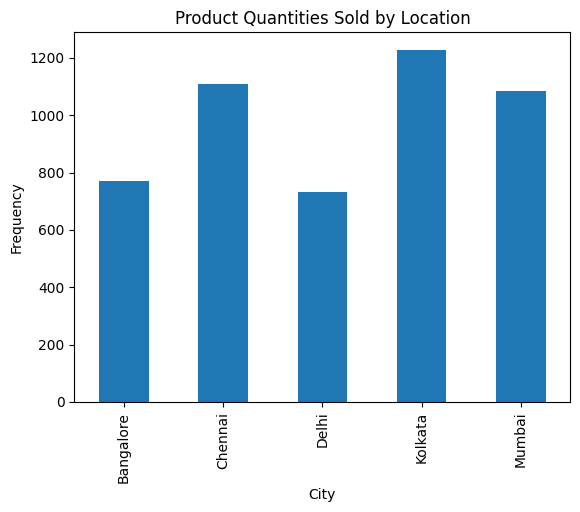

In [19]:
df.groupby('Location')['Order quantities'].sum().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('Product Quantities Sold by Location')
plt.show()


We can find quantities sold per city from the above bar chart

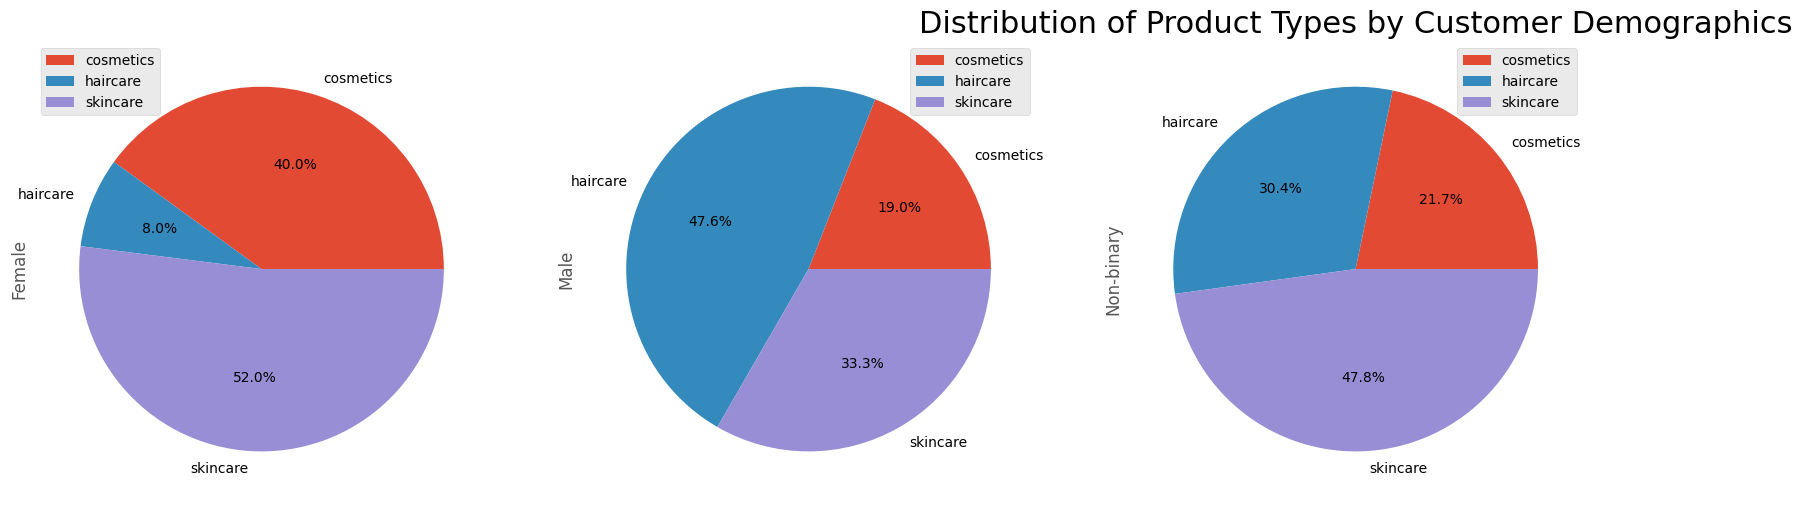

In [21]:
product_types = df[df['Customer demographics'] != 'Unknown'].groupby(['Product type', 'Customer demographics']).size().unstack()
plt.style.use('ggplot')
product_types.plot(kind='pie', subplots=True, figsize=(20, 10), autopct='%1.1f%%')
plt.title('Distribution of Product Types by Customer Demographics', fontsize = 22)
plt.show()

From the above pie chart we can conclude that the female customers are the most interested in skin care and cosmetic products while the male customers are majorly interested in haircare products and the non-binaries are interested in skincare the most.

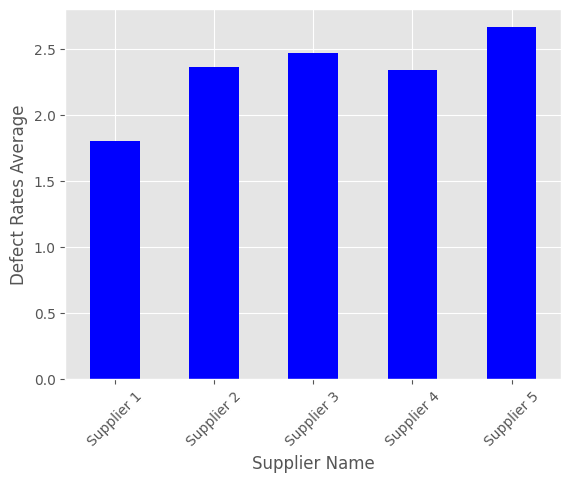

In [22]:
df.groupby('Supplier name')['Defect rates'].mean().plot(kind='bar', color='blue')
plt.xlabel('Supplier Name')
plt.ylabel('Defect Rates Average')
plt.xticks(rotation=45)
plt.show()

From the above bar graph we can conclude that Supplier 5 has the highest average defect rates and Supplier 1 has the lowest

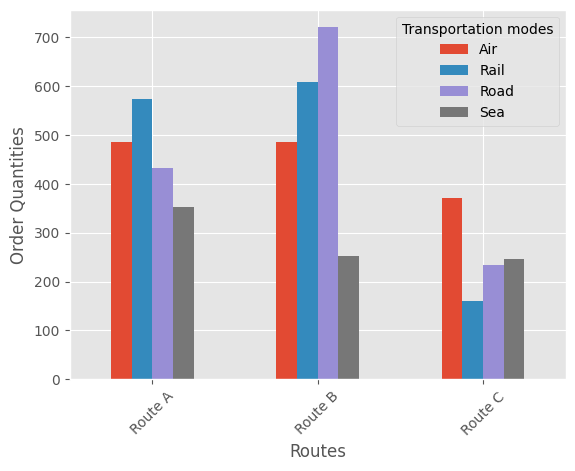

In [23]:
df.groupby(['Routes', 'Transportation modes'])['Order quantities'].sum().unstack().plot(kind='bar')
plt.xlabel('Routes')
plt.ylabel('Order Quantities')
plt.xticks(rotation=45)
plt.show()

The stacked bar chart depicts the distribution of order quantities across different routes, segmented by transportation modes.

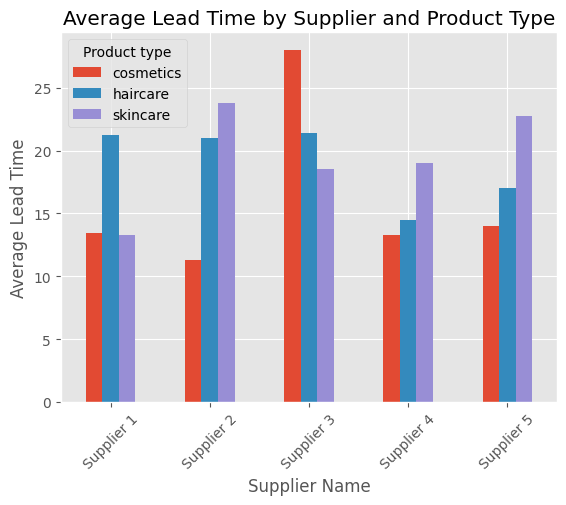

In [24]:
df.groupby(['Supplier name','Product type'])['Lead time'].mean().unstack().plot(kind='bar')
plt.xlabel('Supplier Name')
plt.ylabel('Average Lead Time')
plt.xticks(rotation=45)
plt.title('Average Lead Time by Supplier and Product Type')
plt.show()

The above graph can be used to find out the average lead time for each supplier by product type and can also be used to conclude which type of products on an average take the most time.

C:\Users\sunny\AppData\Local\Temp\ipykernel_32828\2952953689.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=product_types.index)


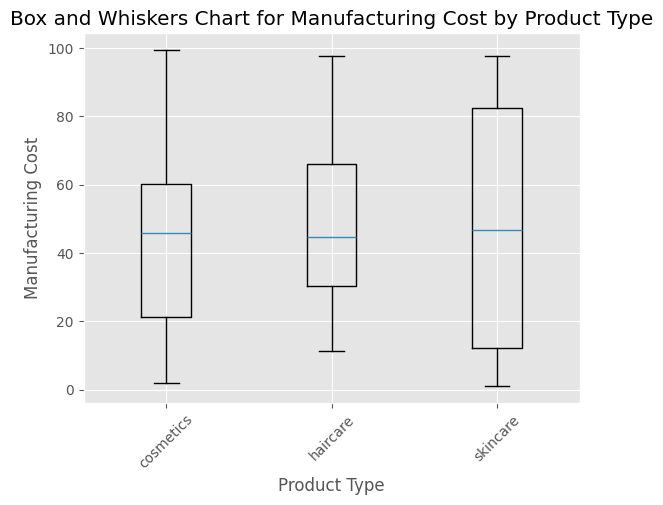

In [25]:
boxplot_data = []

for product_type, data in product_types.iterrows():
    manufacturing_costs = df[df['Product type'] == product_type]['Manufacturing costs']
    boxplot_data.append(manufacturing_costs)

plt.boxplot(boxplot_data, labels=product_types.index)
plt.xlabel('Product Type')
plt.ylabel('Manufacturing Cost')
plt.title('Box and Whiskers Chart for Manufacturing Cost by Product Type')
plt.xticks(rotation=45)
plt.show()

Distribution of Manufacturing cost per product type

C:\Users\sunny\AppData\Local\Temp\ipykernel_32828\3153732791.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=product_types.index)


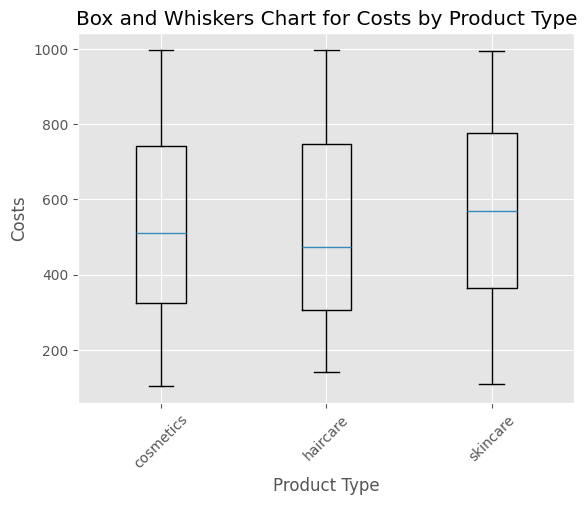

In [26]:

boxplot_data = []

for product_type, data in product_types.iterrows():
    costs = df[df['Product type'] == product_type]['Costs']
    boxplot_data.append(costs)

plt.boxplot(boxplot_data, labels=product_types.index)
plt.xlabel('Product Type')
plt.ylabel('Costs')
plt.title('Box and Whiskers Chart for Costs by Product Type')
plt.xticks(rotation=45)
plt.show()


Distribution of Product cost per product type

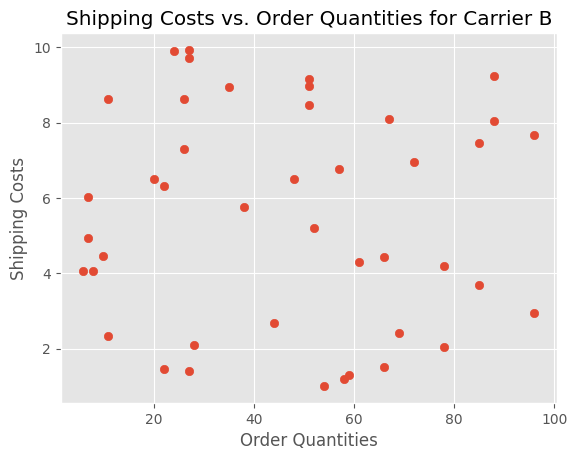

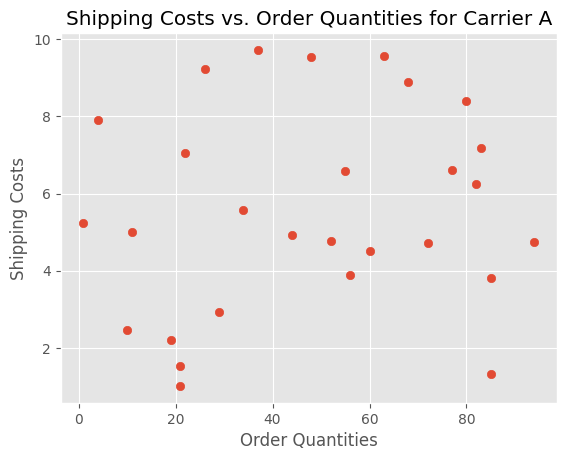

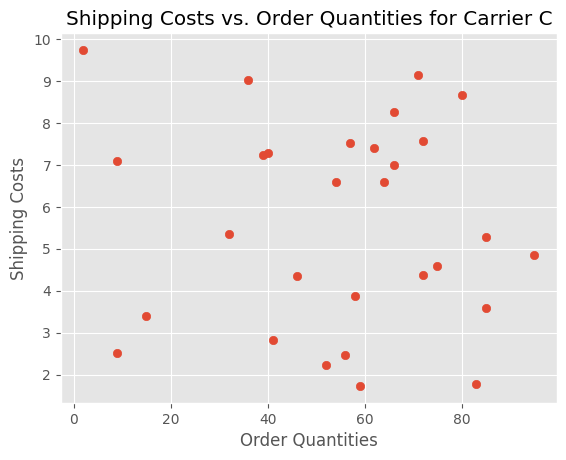

In [27]:
carriers = df['Shipping carriers'].unique()
for carrier in carriers:
    carrier_data = df[df['Shipping carriers'] == carrier]
    plt.scatter(carrier_data['Order quantities'], carrier_data['Shipping costs'], label=carrier)
    plt.title(f'Shipping Costs vs. Order Quantities for {carrier}')
    plt.xlabel('Order Quantities')
    plt.ylabel('Shipping Costs')
    plt.show()


From the above scatter plots we can find out the shipping costs for each order quantity for each carrier.

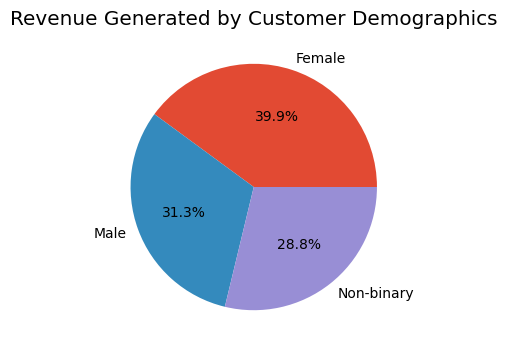

In [28]:
revenue_by_demographics = df[df['Customer demographics']!='Unknown'].groupby('Customer demographics')['Revenue generated'].sum()
plt.figure(figsize=(4, 4))
plt.pie(revenue_by_demographics, labels=revenue_by_demographics.index, autopct='%1.1f%%')
plt.title('Revenue Generated by Customer Demographics')
plt.show()

The above pie chart shows the revenue generated by each customer demographic

In [22]:
#Using Decision Tree Regressor to find out the top 5 features that impact the cost of the product as it can learn non-linear relationships between features


model = DecisionTreeRegressor()
model.fit(df2.drop(['Costs','SKU'], axis=1), df2['Costs'])

importances = model.feature_importances_

features = df2.drop(['Costs'], axis=1).columns

sorted_indices = np.argsort(importances)[::-1]

top_5_features = [features[i] for i in sorted_indices[:5]]

print('Top 5 features that impact cost of the product:')
for feature in top_5_features:
    print(f'\t- {feature}')


Top 5 features that impact cost of the product:
	- Manufacturing costs
	- Lead time
	- Stock levels
	- Price
	- Transportation modes_Sea


In [29]:
model = DecisionTreeRegressor()
model.fit(df2.drop(['Manufacturing lead time','SKU'], axis=1), df2['Manufacturing lead time'])

importances = model.feature_importances_

features = df2.drop(['Manufacturing lead time'], axis=1).columns

sorted_indices = np.argsort(importances)[::-1]

top_5_features = [features[i] for i in sorted_indices[:5]]

print('Top 5 features that impact manufacturing lead time:')
for feature in top_5_features:
    print(f'\t- {feature}')


Top 5 features that impact manufacturing lead time:
	- SKU
	- Shipping times
	- Availability
	- Manufacturing costs
	- Lead times


In [47]:
# ----------  SIMPLE ROI SCENARIO ----------
def roi_air_to_sea(data, pct_shift=0.20, sea_discount=0.30, extra_days=2):
    """
    Estimate quarterly cost impact of shifting % of Air shipments to Sea.

    Assumptions
    -----------
    pct_shift   : fraction of Air moves to convert to Sea (0-1)
    sea_discount: Sea cost is X% cheaper than Air
    extra_days  : lead-time increase for Sea
    """
    air_mask = data["Transportation modes"] == "Air"
    if air_mask.sum() == 0:
        return "No Air shipments present."

    air_cost = data.loc[air_mask, "Shipping costs"].mean()
    sea_cost = air_cost * (1 - sea_discount)
    shipments_q = len(data) * 90/len(data)    # ≈ one shipment per row per day

    savings = shipments_q * pct_shift * (air_cost - sea_cost)
    return (
        f"Switching {pct_shift:.0%} of Air moves to Sea saves "
        f"Rs.{savings:,.0f} per quarter with a {extra_days}-day lead-time penalty."
    )

print(roi_air_to_sea(df))

Switching 20% of Air moves to Sea saves Rs.32 per quarter with a 2-day lead-time penalty.
